# Check version and cuda

In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"cuda: {torch.cuda.is_available()}")

PyTorch version: 2.0.1+cu118
cuda: True


# About parameters
1. batch size
2. device
3. path of dataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
batch_size = 2
training_pth = "/content/drive/MyDrive/Colab Notebooks/UNet/fundus/training"
testing_pth = "/content/drive/MyDrive/Colab Notebooks/UNet/fundus/testing"


# Datasets

## data augmentation
1. randomly augmentation
2. 0:vertical flip, 1: horizontal flip, 2, horizontal and vertical flip, 3: nothing

In [4]:
from torchvision import transforms

transform = {
    0:transforms.Compose([transforms.Grayscale(),
                          transforms.RandomVerticalFlip(p=1.0),
                          transforms.ToTensor()]),
    1:transforms.Compose([transforms.Grayscale(),
                          transforms.RandomHorizontalFlip(p=1.0),
                          transforms.ToTensor()]),
    2:transforms.Compose([transforms.Grayscale(),
                          transforms.RandomHorizontalFlip(p=1.0),
                          transforms.RandomVerticalFlip(p=1.0),
                          transforms.ToTensor()]),
    3:transforms.Compose([transforms.Grayscale(),
                          transforms.ToTensor()])
}

## customized dataset and test it

In [5]:
import os
import random
from PIL import Image

from torch.utils.data import Dataset, DataLoader

class CustomizedDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform

        img_root = os.path.join(root, "images") # image path
        lbl_root = os.path.join(root, "label")  # label path

        img_length = len(os.listdir(img_root))   # length of image
        lel_length = len(os.listdir(lbl_root))   # length of label

        self.img = [f"{img_root}/{i}.png" for i in range(img_length)] # correct road and filename in sequentially
        self.lbl = [f"{lbl_root}/{i}.png" for i in range(lel_length)] # correct road and filename in sequentially

    def __getitem__(self, index):
        image_pth = self.img[index]
        label_pth = self.lbl[index]

        image = Image.open(image_pth)
        label = Image.open(label_pth)

        # augmentation
        flip_code = random.choice([0, 1, 2, 3])
        if self.transform is not None:
            img = self.transform[flip_code](image)
            lbl = self.transform[flip_code](label)

        # convert pixel of label into 0 and 1
        # because out task is segmentation, it actually is a binary classification work
        # set pixel to 0 or 1 to help us classify forward and backward
        # but ToTensor() has alread included this step
#        if lbl.max() > 1:
#            lbl = lbl / 255

        return img, lbl

    def __len__(self):
        return len(self.img)


In [6]:
# test dataloader
train_ds = CustomizedDataset(training_pth, transform)
print(f"length of dataset: {len(train_ds)}\n")

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

i = 0
for image, label in train_dl:
    i += 1
    print(f"batch: {i}\n" + f"-"*15)
    print(f"image size = {image.size()}\nlabel size = {label.size()}\n")

length of dataset: 20

batch: 1
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1, 512, 512])

batch: 2
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1, 512, 512])

batch: 3
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1, 512, 512])

batch: 4
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1, 512, 512])

batch: 5
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1, 512, 512])

batch: 6
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1, 512, 512])

batch: 7
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1, 512, 512])

batch: 8
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1, 512, 512])

batch: 9
---------------
image size = torch.Size([2, 1, 512, 512])
label size = torch.Size([2, 1,

# U-Net architecture
![U-Net architecture][https://reurl.cc/p6eW7d]
1. According to original U-Net architecture, the output size of image will smaller than input
2. so we have to modify slightly its atchitecture making the output size equal input size

## down sampling module

In [7]:
import torch.nn as nn

########## double convolution ##########
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)

        return x

########## down sampling ##########
class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sampling = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.down_sampling(x)

        return x



## up sampling module
(1) In up sampling stage, it include two step

1. first, use transpose convolution (or bilinear) to enlarge each feather map
2. second, padding the feature map from up sampling then concact another feature map from down sampling

(2) reference: https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad (F.pad)

In [8]:
import torch.nn.functional as F

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        if bilinear:
            self.up = nn.Unsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2, padding=0)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        parameters
        -----
        x1: features after upsample, size = [batch, C, H, W]
        x2: features in skip architecture, size = [batch, C, H, W]
        """

        x1 = self.up(x1)

        diff_h = torch.tensor(x2.size()[2] - x1.size()[2]) # difference of hight
        diff_w = torch.tensor(x2.size()[3] - x1.size()[3]) # difference of width

        # padding
        ######################################################
        # padding參數如果設為[diff_w//2, diff_w//2, diff_h//2, diff_h//2], 則只能針對邊長差為偶數的使用
        # ex:  (H, W)=(3, 3) -> (H, W)=(7, 7) 或 (H, W)=(2, 2) -> (H, W)=(8, 8)
        # 若是邊長差為奇數, 則會有少padding的情況發生
        # ex: (H, W)=(3, 3) -> (H, W)=(10, 10)
        # 因此應該寫成[diff_w//2, diff_w - diff_w//2, diff_h//2, diff_h - diff_h//2]
        ######################################################
        x1 = F.pad(x1, [diff_w//2, diff_w - diff_w//2, diff_h//2, diff_h - diff_h//2])

        # concat and convolution
        x = torch.cat([x2, x1], dim=1) # concat along channel dimension
        x = self.conv(x)

        return x


## output convolution

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)

        return x

# Completed U-Net model
for instance, **input size (C, H, W)=(1, 512, 512)**

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        """
        parameter
        ----------
        n_channels: intput channel
        n_classes: number of class

        """
        super().__init__()

        # down sampling
        self.in_channels = DoubleConv(n_channels, 64) # [1, 512, 512]   -> [64, 512, 512]  -> [64, 512, 512]
        self.down_1 = DownSampling(64, 128)           # [64, 512, 512]  -> [64, 256, 256]  -> [128, 256, 256] -> [128, 256, 256]
        self.down_2 = DownSampling(128, 256)          # [128, 256, 256] -> [128, 128, 128] -> [256, 128, 128] -> [256, 128, 128]
        self.down_3 = DownSampling(256, 512)          # [256, 128, 128] -> [256, 64, 64]   -> [512, 64, 64]   -> [512, 64, 64]
        self.down_4 = DownSampling(512, 1024)         # [512, 64, 64]   -> [512, 32, 32]   -> [1024, 32, 32]  -> [1024, 32, 32]

        # up sampling
        self.up_1 = Up(1024, 512, bilinear) # [1024, 32, 32]  -> [1024, 64, 64]  -> [512, 64, 64]   -> [512, 64, 64]
        self.up_2 = Up(512, 256, bilinear)  # [512, 64, 64]   -> [512, 128, 128] -> [256, 128, 128] -> [256, 128, 128]
        self.up_3 = Up(256, 128, bilinear)  # [256, 128, 128] -> [256, 256, 256] -> [128, 256, 256] -> [128, 256, 256]
        self.up_4 = Up(128, 64, bilinear)   # [128, 256, 256] -> [128, 512, 512] -> [64, 512, 512]  -> [64, 512, 512]

        # output
        self.out_channels = OutConv(64, n_classes)

    def forward(self, x):
        # down sampling
        x1 = self.in_channels(x)
        x2 = self.down_1(x1)
        x3 = self.down_2(x2)
        x4 = self.down_3(x3)
        x5 = self.down_4(x4)

        # up sampling
        x = self.up_1(x5, x4)
        x = self.up_2(x, x3)
        x = self.up_3(x, x2)
        x = self.up_4(x, x1)
        x = self.out_channels(x)

        return x



In [11]:
# observe model architecture
model = UNet(n_channels=1, n_classes=1)
for name, layer in model.named_children():
    print(name)
    print(layer)

in_channels
DoubleConv(
  (double_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
)
down_1
DownSampling(
  (down_sampling): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
from torchsummary import summary

summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

# Training

## dataset

In [12]:
batch_size = 5
train_ds = CustomizedDataset(training_pth, transform)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

## model, loss and optimizer

In [13]:
from torch import optim

# model setting
n_channels = 1
n_classes = 1
model = UNet(n_channels, n_classes)
model = model.to(device)

# loss and optimizer
lr = 0.00001
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=1e-8, momentum=0.9)
epochs = 50

## training

In [14]:
import time

model.train()
best_loss = float("inf")
loss_list = []

since = time.time()
for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch}/{epochs}")
    print('-' * 15)

    batch_loss = 0

    for data, label in train_dl:
        data, label = data.to(device, dtype=torch.float32), label.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item() * data.size(0)

    epoch_loss = batch_loss / len(train_ds)
    loss_list.append(epoch_loss)
    print(f"loss: {epoch_loss:.6f}\n")

    if epoch_loss < best_loss:
        best_model_weight = model.state_dict()

times = time.time() - since
print(f"training time: {times//3600} hr {(times//60)%60} min {times%60} sec")


Epoch: 1/50
---------------
loss: 0.700443

Epoch: 2/50
---------------
loss: 0.583812

Epoch: 3/50
---------------
loss: 0.520095

Epoch: 4/50
---------------
loss: 0.472994

Epoch: 5/50
---------------
loss: 0.440371

Epoch: 6/50
---------------
loss: 0.420152

Epoch: 7/50
---------------
loss: 0.407083

Epoch: 8/50
---------------
loss: 0.394899

Epoch: 9/50
---------------
loss: 0.385398

Epoch: 10/50
---------------
loss: 0.374362

Epoch: 11/50
---------------
loss: 0.367852

Epoch: 12/50
---------------
loss: 0.368639

Epoch: 13/50
---------------
loss: 0.364101

Epoch: 14/50
---------------
loss: 0.356684

Epoch: 15/50
---------------
loss: 0.352007

Epoch: 16/50
---------------
loss: 0.347091

Epoch: 17/50
---------------
loss: 0.343455

Epoch: 18/50
---------------
loss: 0.339819

Epoch: 19/50
---------------
loss: 0.335475

Epoch: 20/50
---------------
loss: 0.332111

Epoch: 21/50
---------------
loss: 0.328691

Epoch: 22/50
---------------
loss: 0.326467

Epoch: 23/50
------

## visualize

Text(0.5, 1.0, 'Loss')

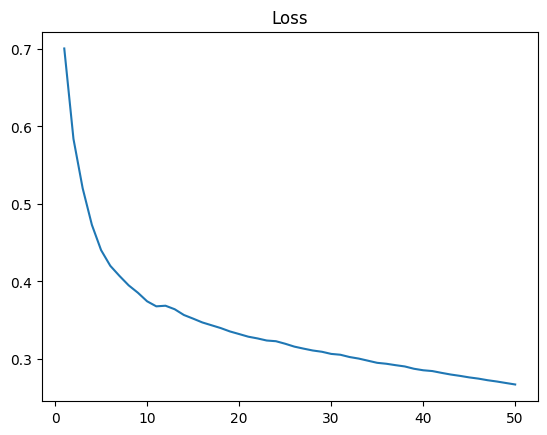

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), loss_list)
plt.title("Loss")

# Testing

In [18]:
########## transform ##########
transform_test = transforms.Compose([transforms.Grayscale(),
                                     transforms.ToTensor()])

########## dataset and dataloader ##########
class TestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform

        img_path = os.path.join(root, "images") # image path
        lbl_path = os.path.join(root, "label")  # label path

        img_length = len(os.listdir(img_path))  # image length
        lbl_length = len(os.listdir(img_path))    # label length

        self.img = [f"{img_path}/{i}.png" for i in range(1, img_length+1)]
        self.lbl = [f"{lbl_path}/{i}.png" for i in range(1, lbl_length+1)]

    def __getitem__(self, index):
        image_path = self.img[index]
        label_path = self.lbl[index]

        img = Image.open(image_path)
        lbl = Image.open(label_path)

        if self.transform is not None:
            img = self.transform(img)
            lbl = self.transform(lbl)

        return img, lbl

    def __len__(self):
        return len(self.img)

########## check dataset and dataloader ##########
batch_size = 1
test_ds = TestDataset(testing_pth, transform=transform_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

i = 0
for img, lbl in test_dl:
    i += 1
    print(f"time: {i}")
    print('-' * 15)
    print(f"image size: {img.size()}\nlabel size: {lbl.size()}\n")


time: 1
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 2
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 3
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 4
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 5
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 6
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 7
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 8
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 9
---------------
image size: torch.Size([1, 1, 512, 512])
label size: torch.Size([1, 1, 512, 512])

time: 10
---------------
image size: 

In [20]:
from sklearn.metrics import confusion_matrix

########## compute iou score ##########
def IOU(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    iou = tp / (fp + fn + tp)

    return iou

########## testing ##########
save_path = "/content/drive/MyDrive/Colab Notebooks/UNet/fundus/testing/label"

model.load_state_dict(best_model_weight)
model.to(device)
model.eval()

iou_list = []
with torch.no_grad():
    for i, (data, label) in enumerate(test_dl):
        print(f"batch: {i+1}")
        print('-' * 15)
        data, label = data.to(device, dtype=torch.float32), label.to(device, dtype=torch.float32)

        output = model(data) # output size: [b, C, H, W]=[1, 1, 512, 512]

        ############### save predicted image ###############
        pred = torch.squeeze(output, dim=1)      # pred_img size = [1, 512, 512]
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        pred_img = transforms.ToPILImage()(pred) # convert into PIL format
        pred_img.save(f"{save_path}/{i+1}_pred.png")

        print("save image: complete !")
        ####################################################

        ############## compute mean iou score ##############
        y_true = torch.flatten(label)
        y_true[y_true >= 0.5] = 1
        y_true[y_true < 0.5] = 0
        y_true = y_true.detach().cpu().numpy()

        y_pred = torch.flatten(pred)
        y_pred = y_pred.detach().cpu().numpy()

        iou = IOU(y_true, y_pred)
        iou_list.append(iou)

        print("compute iou: complete !")
        ####################################################

print(f"mean IOU score: {sum(iou_list)/len(iou_list)}")


batch: 1
---------------
save image: complete !
compute iou: complete !
batch: 2
---------------
save image: complete !
compute iou: complete !
batch: 3
---------------
save image: complete !
compute iou: complete !
batch: 4
---------------
save image: complete !
compute iou: complete !
batch: 5
---------------
save image: complete !
compute iou: complete !
batch: 6
---------------
save image: complete !
compute iou: complete !
batch: 7
---------------
save image: complete !
compute iou: complete !
batch: 8
---------------
save image: complete !
compute iou: complete !
batch: 9
---------------
save image: complete !
compute iou: complete !
batch: 10
---------------
save image: complete !
compute iou: complete !
batch: 11
---------------
save image: complete !
compute iou: complete !
batch: 12
---------------
save image: complete !
compute iou: complete !
batch: 13
---------------
save image: complete !
compute iou: complete !
batch: 14
---------------
save image: complete !
compute iou

# Conclusion
一些血管中**更細微的末梢血管**不能很好的分割